In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt 
from matplotlib.patches import Rectangle
from IPython.display import Image, display
import pandas as pd

#### Functions

In [31]:
def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if (fmask[j, i]== 0):
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+1]-w_depths[j])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)

def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel,NW=False):
    
    if NW == True:
        latgridf = latgridi-1 #actually lon
        fmask = mesh.fmask[0,:,:,latgridf] # Giving mask of longitudes
        tmask = mesh.tmask[0]
        
        lons = data.init_lat[(data.final_section != 0)]
        
        f_lons = mesh.gphif[0,:, latgridf]
        u_lons = mesh.gphiv[0,:, latgridf]
        w_depths = mesh.gdepw_1d
    else:
        latgridf = latgridi-1
        fmask = mesh.fmask[0, :, latgridf]
        tmask = mesh.tmask[0]
            
        lons = data.init_lon[(data.final_section != 0)]
            
        f_lons = mesh.glamf[0, latgridf]
        u_lons = mesh.glamv[0, latgridf]
        w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.dense
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE+1:1]/m2lon),w_depths[0,0:depi+1]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    try:
        im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    except:
        im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time),cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Latitude (°W)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(f_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

### Import data

In [9]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [15]:
file1 = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/combined_from_ariane/prtoadm_haro_finalsalt.csv')
file2 = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/combined_from_ariane/prtoadm_haro_finaltransp.csv')


pathway = ['prtoadm_haro','prtovs_haro','prtogulf_haro','prtoadm_ros','prtovs_ros','vstopr_haro','vstogulf_haro','vstoadm_haro']
variables = ['finalsalt','finaltransp','finaltemp','initsalt','inittransp','inittemp','finallat','finallon','initlat','initlon','initz','finalz']
dict_all = {}
for pathw in pathway:
    dict_all[pathw] = {}
    for variable in variables:
        fpath = f'/ocean/cstang/MOAD/analysis-camryn/combined_from_ariane/{pathw}_{variable}.csv'
        dict_all[pathw][variable] = pd.read_csv(fpath)


dict_keys(['finalsalt', 'finaltransp', 'finaltemp', 'initsalt', 'inittransp', 'inittemp', 'finallat', 'finallon', 'initlat', 'initlon', 'initz', 'finalz'])

In [22]:

dict_all['prtoadm_ros']['finallat']

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,48.153544,48.149993,48.140759,48.141208,48.135507,48.149079,48.139673,48.141227,48.136588,48.148130,48.152345,48.141539
1,48.151862,48.140651,48.145942,48.147399,48.142647,48.151364,48.139294,48.152850,48.147230,48.151649,48.142447,48.140026
2,48.155045,48.153360,48.139377,48.134040,48.154600,48.142542,48.141388,48.147384,48.141502,48.147881,48.154025,48.149518
3,48.148398,48.142138,48.143698,48.150577,48.151145,48.148709,48.154093,48.149777,48.149626,48.140552,48.155053,48.152741
4,48.152143,48.148258,48.142457,48.146799,48.156175,48.149213,48.139716,48.149013,48.154386,48.148353,48.145489,48.147448
...,...,...,...,...,...,...,...,...,...,...,...,...
8407,NaN,NaN,NaN,NaN,NaN,NaN,48.148566,NaN,NaN,NaN,NaN,NaN
8408,NaN,NaN,NaN,NaN,NaN,NaN,48.136673,NaN,NaN,NaN,NaN,NaN
8409,NaN,NaN,NaN,NaN,NaN,NaN,48.153562,NaN,NaN,NaN,NaN,NaN
8410,NaN,NaN,NaN,NaN,NaN,NaN,48.143724,NaN,NaN,NaN,NaN,NaN


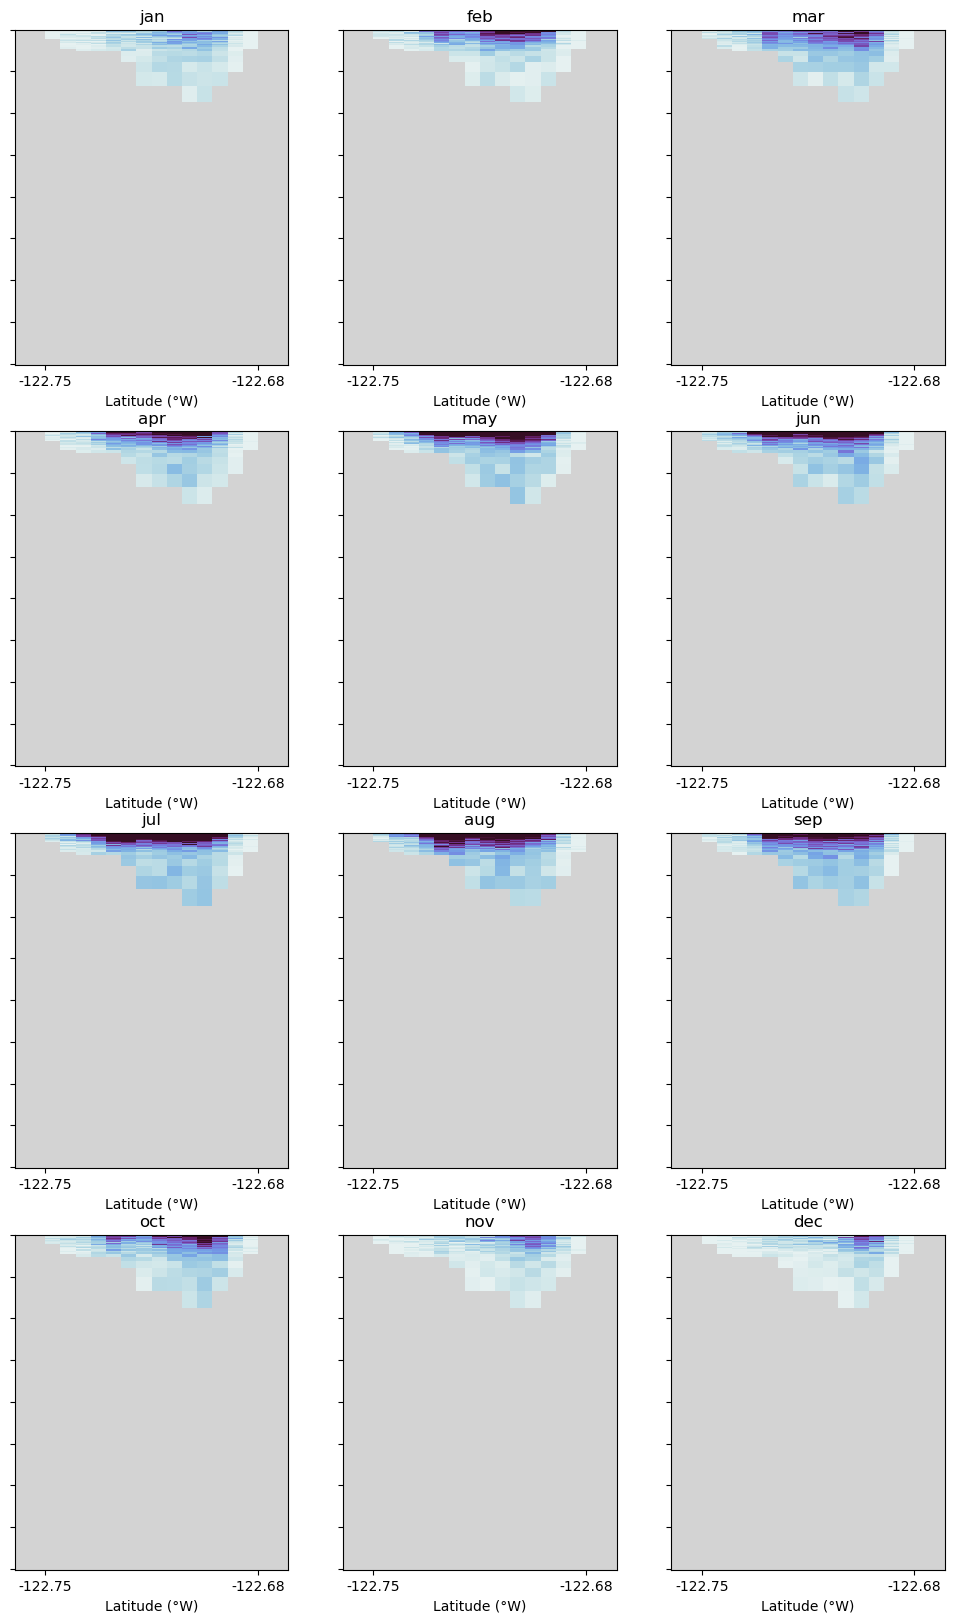

In [33]:
lonWpr = 260
lonEpr = 310
latpr = 386
lonWros=283
lonEros=305
latros = 267
lonWvs = 235
lonEvs = 301
latvs = 166
lonWadm = 250
lonEadm = 268
latadm = 200

months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

fig,[[ax1,ax2,ax3],[ax4,ax5,ax6],[ax7,ax8,ax9],[ax10,ax11,ax12]] = plt.subplots(4,3,figsize=(12,20))

for ii,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]):
    plotCS(ax,dict_all['prtoadm_ros']['finallon'][months[ii]].dropna(),dict_all['prtoadm_ros']['finalz'][months[ii]].dropna(),dict_all['prtoadm_ros']['finaltransp'][months[ii]].dropna(),lonWadm,lonEadm,latadm,38,0.02,23*30,months[ii],False,False)

In [19]:
dict_all['prtoadm_ros']['finallat'][months[ii]].dropna()

0       48.141539
1       48.140026
2       48.149518
3       48.152741
4       48.147448
          ...    
1490    48.151629
1491    48.154393
1492    48.134673
1493    48.155536
1494    48.151406
Name: dec, Length: 1495, dtype: float64